[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DanielAlonsoBastos/AprendizajeProfundo/blob/main/tarea2-cnn-recurrentes-transferencia/3_ucf11.ipynb)

# Reconocimiento de acciones humanas
Daniel Alejandro Alonso Bastos

Comparación de arquitecturas RNN y CNN para reconocimiento de acciones humanas en el conjunto [UCF11](https://cloud.xibalba.com.mx/s/apYrNA4iM4K65o7). La solución debe de cumplir con los siguientes puntos:

* Usar las características convolucionales vistas en clase.
* Implementar una arquitectura RNN bidireccional con una capa GRU.
* Implementar una arquitectura CNN con una capa Conv1d.
* Modificar el tamaño de las capas para que ambos modelos tengan un número similar de parámetros.
* Discutir el comportamiento durante el entrenamiento y resultados finales en ambos conjuntos.

## 1 Preparación

1.1 Bibliotecas

In [1]:
# inspeccionar arquitecturas
!pip install torchinfo
!pip install zarr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# sistema de archivos
import os
# funciones aleatorias
import random
# descomprimir
import tarfile
# sistema de archivos
from os.path import join

# arreglos multidimensionales
import numpy as np
import matplotlib.pyplot as plt

# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets.utils as tvu
# almacenamiento de arreglos multidimensionales
import zarr
#redes
from torch.utils.data import DataLoader, random_split
# barras de progreso
from tqdm.auto import tqdm
from tqdm.auto import trange
# inspección de arquitectura
from torchinfo import summary

# directorio de datos
DATA_DIR = '../data'
# tamaño del lote
BATCH_SIZE = 32
# tamaño del vector de características
FEAT_SIZE = 1024
# tamaño del conjunto de entrnamiento
TRN_SIZE = 0.8

# parametros para graficas
MARKER = 'o'
MARKER_SIZE = 4

### 1.2 Auxiliares

In [3]:
# reproducibilidad
def set_seed(seed=0):
  """Initializes pseudo-random number generators."""
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
# settear semilla
set_seed()

# grafica de perdida y accuracy del modelo
def plot_loss_accuracy(loss_hist, accuracy_hist):
  train_loss, test_loss = zip(*loss_hist)
  train_acc, test_acc = zip(*accuracy_hist)

  fig,ax = plt.subplots(1,2,figsize=(16,5))

  ax[0].plot(train_loss,label='Train',marker=MARKER,markersize=MARKER_SIZE)
  ax[0].plot(test_loss,label='Test',marker=MARKER,markersize=MARKER_SIZE)
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Loss')
  ax[0].set_title('Model loss')
  ax[0].grid()
  ax[0].legend()

  ax[1].plot(train_acc,label='Train',marker=MARKER,markersize=MARKER_SIZE)
  ax[1].plot(test_acc,label='Test',marker=MARKER,markersize=MARKER_SIZE)
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Accuracy (%)')
  ax[1].set_title('Model accuracy')
  ax[1].set_ylim([0,100])
  ax[1].grid()
  ax[1].legend()

  plt.show()

## 2 Datos

### 2.1 Conjunto de datos

En la clase `UCF11` se realiza la tubería de datos, en la cual se descargan y descomprimen las características convolucionales obtenidas en notebook [3b_ucf11_feats](https://github.com/gibranfp/CursoAprendizajeProfundo/blob/2023-1/notebooks/3b_ucf11_feats.ipynb), el cual contiene 10 cuadros por video, y en cada cuadro se tiene un vector de 1,024 características, dichas características fueron extraídas empleando una DenseNet121.

In [4]:
class UCF11:

    def __init__(self, root, download=False):
        self.root = root
        self.zarr_dir = join(root, 'ucf11.zarr')
        if download:
            self.download()
        self.z = zarr.open(self.zarr_dir, 'r')
        self.paths = list(self.z.array_keys())
        
    def __getitem__(self, i):
        arr = self.z[self.paths[i]]
        x = np.array(arr)
        y = np.array(arr.attrs['y'], dtype=np.int64)
        return x, y

    def __len__(self):
        return len(self.paths)
    
    def _check_integrity(self):
        return os.path.isdir(self.zarr_dir)
    
    def _extract(self, root, filename):
        tar = tarfile.open(join(root, filename), "r:gz")
        tar.extractall(root)
        tar.close()

    def download(self):
        if self._check_integrity():
            print('Files already downloaded and verified')
            return

        tvu.download_url(
            url='https://cloud.xibalba.com.mx/s/apYrNA4iM4K65o7/download',
            root=self.root,
            filename='ucf11.zarr.tar.gz',
            md5='c8a82454f9ec092d00bcd99c849e03fd'
        )
        self._extract(self.root, 'ucf11.zarr.tar.gz')

A continuación se genera una instancia de UCF11 y se descarga el conjunto de datos que tiene las características convolucionales obtenidas del notebook [3b_ucf11_feats.ipynb](https://github.com/gibranfp/CursoAprendizajeProfundo/blob/2023-1/notebooks/3b_ucf11_feats.ipynb).

In [5]:
ds = UCF11(join(DATA_DIR, 'ucf11'), True)
x, y = ds[0]
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'x [0][:5]={x[0][:5]}')
print(f'y shape={y.shape} dtype={y.dtype} {y}')
print(f'y {y}')

Files already downloaded and verified
x shape=(10, 1024) dtype=float32
x [0][:5]=[0.00022111 0.00368518 0.00314753 0.00201778 0.09296297]
y shape=() dtype=int64 0
y 0


Se realiza la partición del conjunto de entrenamiento (80%) y prueba (20%)

In [6]:
trn_size = int(TRN_SIZE * len(ds))
tst_size = len(ds) - trn_size
trn_ds, tst_ds = random_split(ds, [trn_size, tst_size])
len(trn_ds), len(tst_ds)

(1279, 320)

### 2.2 Cargadores de datos

In [7]:
trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True,
    # procesos paralelos
    num_workers=2
)
tst_dl = DataLoader(
    # conjunto
    tst_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True,
    # procesos paralelos
    num_workers=2
)

El tensor $x$ consiste en: [lote, secuancia, vector de características]

In [8]:
x, y = next(iter(trn_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')

x shape=torch.Size([32, 10, 1024]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


## 3 Modelos

### 3.1 Arquitectura RNN bidireccional con una capa GRU

En la clase `RNN` se define una arquitectura RNN parametrizada, en la cual se puede seleccionar si es o no bidireccional. En caso de emplear un GRU bidireccional el tamaño a la salida se duplica, por lo que la entrada a la capa completamente conectada tiene que considerar el doble de entrada.

In [9]:
class RNN(nn.Module):
  def __init__(self,bidirectional=False, input_size = 1024, 
               hidden_size=128, num_classes=11, p_drop=0.0):
    super().__init__()
    self.p_drop = p_drop # probabilidad de que un elemento sea 0
    
    # si RNN es bidireccional, entonces se tiene el doble de estados a la salida
    num_directions = 2 if bidirectional else 1

    self.bn = nn.BatchNorm1d(input_size)
    self.rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size, 
                      num_layers=1, batch_first=True, 
                      bidirectional=bidirectional)
    self.cls = nn.Linear(num_directions*hidden_size, num_classes)

    # dropout
    self.dropout = nn.Dropout(self.p_drop)

  def forward(self, x):
    # el vector de caracteristicas convolucionales es [B,S,F]
    # B -> batch, S -> seq, F -> features
    # [B,S,F] => [B,F,S]
    x = x.movedim(1, 2)
    x = self.bn(x) # [B,F,S]
    # [B,F,S] => [B,S,F]
    x = x.movedim(1, 2)
    # [B,S,F] => [B,S,H]
    # si es bidireccional -> [B,S,F] => [B,S,2*H]
    x = self.dropout(x)
    x, _ = self.rnn(x)
    # [B, S, H] => [B, H]
    #x = x[:, -1, :]
    x = torch.mean(x,1)
    # [B, H] = [B, 11]
    x = self.dropout(x)
    x = self.cls(x)
    return x

Instancia y prueba de la arquitectura

In [10]:
# RNN bidireccional
model_RNNBid = RNN(bidirectional=True)
model_RNNBid(torch.zeros(1, 10, 1024)).shape

torch.Size([1, 11])

In [11]:
# RNN
model_RNN = RNN()

### 3.2 Arquitectura CNN con una capa Conv1d

En la clase `CNN` se define una arquitectura CNN que tiene una capa de convolución 1D adentro, en función de los parámetros de la convolución el vector de características tendrá un tamaño distinto a la salida. El tamaño de salida de la convolución 1D se calcula con la siguiente [ecuación](https://stackoverflow.com/questions/62162576/calculating-shape-of-conv1d-layer-in-pytorch):


\begin{equation}
L_{out} = \left \lfloor \frac{L_{in}+2\times padding - dilation \times \left ( kernel_{size}-1 \right )-1}{stride}+1 \right \rfloor
\end{equation}


El cálculo de la salida se agrega como un método de la clase para calcular el tamaño del número de unidades en la entrada de la capa completamente conectada.


In [12]:
class CNN(nn.Module):
  def __init__(self, input_size = 1024, in_channels = 10, out_channels = 10, 
               kernel_size = 3, num_classes=11):
    super().__init__()

    # calculo de la salida del vector de caract despues de la conv1d
    input_size_cls_cnn = self._calculate_output_conv1d(input_size, kernel_size)
    
    self.bn = nn.BatchNorm1d(input_size)
    self.cnn = nn.Conv1d(in_channels,out_channels,kernel_size)
    self.cls = nn.Linear(input_size_cls_cnn, num_classes)

  def _calculate_output_conv1d(self, in_size, kernel_size, stride=1, padding=0, dilation=1):
    return (in_size + 2 * padding - dilation * (kernel_size - 1) - 1) // stride + 1

  def forward(self, x):
    # el vector de caracteristicas convolucionales es [B,S,F]
    # B -> batch, S -> seq, F -> features
    # [B,S,F] => [B,F,S]
    x = x.movedim(1, 2)
    x = self.bn(x) # [B,F,S]
    # [B,F,S] => [B,S,F]
    x = x.movedim(1, 2)
    # [B,S,F] => [B,S,H]
    # si es bidireccional -> [B,S,F] => [B,S,2*H]
    x = self.cnn(x)
    # [B, S, H] => [B, H]
    #x = x[:, -1, :]
    x = torch.mean(x,1)
    # [B, H] = [B, 11]
    x = self.cls(x)
    return x

Instancia y prueba de la arquitectura

In [13]:
model_CNN = CNN()
model_CNN(torch.zeros(1, 10, 1024)).shape

torch.Size([1, 11])

### 3.3 Modificar el tamaño de las capas para que ambos modelos tengan un número similar de parámetros

Para modificar el tamaño de las capas, se entendió cuáles son los hiperparámetros que mayor impacto tenían en el número de parámetros entrenables del modelo.
* En el caso de la CNN es el número de canales que se tendrá a la salida de la convolución 1d.
* En el caso de la RNN es si es bidireccional o no, porque duplica el número de parámetros de la capa completamente conectada, y también el tamaño a la salida de la GRU.

Se variaron tanto el número de canales a la salida de la convolución y el tamaño de salida para tener un número cercano de parámetros en ambos modelos.

In [14]:
model_CNN_M = CNN(out_channels=650)
summary(model_CNN_M, (1,10,1024), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 11]                   --
├─BatchNorm1d: 1-1                       [1, 1024, 10]             2,048
├─Conv1d: 1-2                            [1, 650, 1022]            20,150
├─Linear: 1-3                            [1, 11]                   11,253
Total params: 33,451
Trainable params: 33,451
Non-trainable params: 0
Total mult-adds (M): 20.61
Input size (MB): 0.04
Forward/backward pass size (MB): 5.40
Params size (MB): 0.13
Estimated Total Size (MB): 5.57

In [15]:
model_RNNBid_M = RNN(bidirectional=True, hidden_size=5)
summary(model_RNNBid_M, (1,10,1024), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
RNN                                      [1, 11]                   --
├─BatchNorm1d: 1-1                       [1, 1024, 10]             2,048
├─Dropout: 1-2                           [1, 10, 1024]             --
├─GRU: 1-3                               [1, 10, 10]               30,930
├─Dropout: 1-4                           [1, 10]                   --
├─Linear: 1-5                            [1, 11]                   121
Total params: 33,099
Trainable params: 33,099
Non-trainable params: 0
Total mult-adds (M): 0.31
Input size (MB): 0.04
Forward/backward pass size (MB): 0.08
Params size (MB): 0.13
Estimated Total Size (MB): 0.26

## 4 Entrenamiento

In [16]:
! nvidia-smi

Sat Nov 12 01:46:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [17]:
# obtenemos dispositivo en gpu, si no en cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### 4.1 Ciclo de entrenamiento

In [18]:
def train_epoch(data_loader,model,opt,epoch):
  # loop sobre cada lote en el conjunto de entrenamiento
  for x, y_true in data_loader:
  #for x, y_true in tqdm(data_loader, desc=f'E{epoch:2d} Train'):
    # mover a dispositivo
    x = x.to(device)
    y_true = y_true.to(device)
    # se realiza inferencia
    y_lgts = model(x)
    # se calcula la perdida
    loss = F.cross_entropy(y_lgts, y_true)
    # backprop
    opt.zero_grad() # vaciar los gradientes
    loss.backward() # retropropagamos
    opt.step() # actualizamos parametros

def eval_epoch(data_loader, model, epoch):
  # evitar que se regsitren las operaciones en la grafica de computo
  with torch.no_grad():
    # listas para guardar historiales de perdidas y accuracy
    losses, accs = [], []
    # validación de la época con num_batches
    # si num_batches==None, se usan todos los lotes
    for x, y_true in data_loader:
    #for x, y_true in tqdm(data_loader, desc=f'E{epoch:2d} Test'):
      # mover a dispositivo
      x = x.to(device)
      y_true = y_true.to(device)
      y_lgts = model(x) # calculamos logits
      # calculo de las probabilidades
      y_prob = F.softmax(y_lgts, 1)
      # obtencion de la clase predicha
      y_pred = torch.argmax(y_prob, 1)
      # calculo de metricas
      loss_b = F.cross_entropy(y_lgts, y_true) # calculo de la perdida
      acc_b = (y_true == y_pred).type(torch.float32).mean() # calculo de la exactitud
      # guardar historial de las metricas
      losses.append(loss_b.item()*100)
      accs.append(acc_b.item()*100)
    
    # se obtiene el promedio de las metricas
    loss = np.mean(losses)
    acc = np.mean(accs)
    return loss, acc

def train(model, train_dl, test_dl,epochs=10,lr=1e-3,opt='Adam',
          L2lambda=0, seed=True, progress=True):
  #if seed: set_seed() # fijar semilla para reproducibilidad
  set_seed()
  # mover modelo a cpu/gpu
  model = model.to(device)
  # historiales
  loss_hist, acc_hist = [], []

  # optimizadores
  # optimizador seleccionado
  if opt == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=L2lambda)
  if opt == 'RMSprop':
    optimizer = optim.RMSprop(model.parameters(),lr=lr, weight_decay=L2lambda)
  if opt == 'Adam':
    optimizer = optim.Adam(model.parameters(),lr=lr, weight_decay=L2lambda)

  # definir si se quiere o no imprimir el progreso
  range_progress = trange(epochs)  if progress else range(epochs)

  # colocar el modelo en modo de evaluacion
  model.eval()

  # ciclo de entrenamiento
  for epoch in range_progress:
    # colocar al modelo en modo de entrenamiento
    model.train()
    # entrenamiento de la epoca
    train_epoch(train_dl,model,optimizer,epoch)
    # modelo en modo evaluacion
    model.eval()
    # evaluacion de la epoca en el conjunto de entrenamiento y prueba
    train_loss, train_acc = eval_epoch(train_dl, model, epoch)
    test_loss, test_acc = eval_epoch(test_dl, model, epoch)
    # actualizar historial
    loss_hist.append([train_loss,test_loss])
    acc_hist.append([train_acc, test_acc])

    # impresion del progreso
    if progress:
      print(f'E{epoch:02} '
            f'loss=[{train_loss:6.2f},{test_loss:6.2f}] '
            f'acc=[{train_acc:6.2f},{test_acc:6.2f}] ')
      
  return loss_hist, acc_hist

### 4.2 Entrenamiento de la arquitectura RNN bidireccional

En esta sección se realiza el entrenamiento de una arquitectura RNN bidireccional. Se realizaron un par de ejercicios al variar la tasa de aprendizaje `lr=1e-3` y `lr=1e-4`.

De ambos ejercicios se observa un claro overfitting, pero con una tasa de aprendizaje mayor se alcanzó una mejor exactitud en la primera época, después de dicha época el modelo comienza a sobreajustar.

In [24]:
loss_rnnbid, acc_rnnbid = train(model_RNNBid, trn_dl, tst_dl,epochs=10,lr=1e-4,
                        opt='Adam',progress=True)

  0%|          | 0/10 [00:00<?, ?it/s]

E00 loss=[148.83,167.61] acc=[ 58.17, 47.19] 
E01 loss=[144.47,164.78] acc=[ 60.12, 47.81] 
E02 loss=[139.77,161.92] acc=[ 61.60, 49.06] 
E03 loss=[135.36,159.31] acc=[ 63.88, 50.00] 
E04 loss=[131.12,156.65] acc=[ 64.58, 49.38] 
E05 loss=[127.02,155.70] acc=[ 66.13, 50.94] 
E06 loss=[123.48,153.04] acc=[ 68.02, 51.56] 
E07 loss=[119.72,151.11] acc=[ 68.09, 51.25] 
E08 loss=[115.39,148.62] acc=[ 70.76, 51.88] 
E09 loss=[111.77,147.79] acc=[ 71.54, 52.50] 


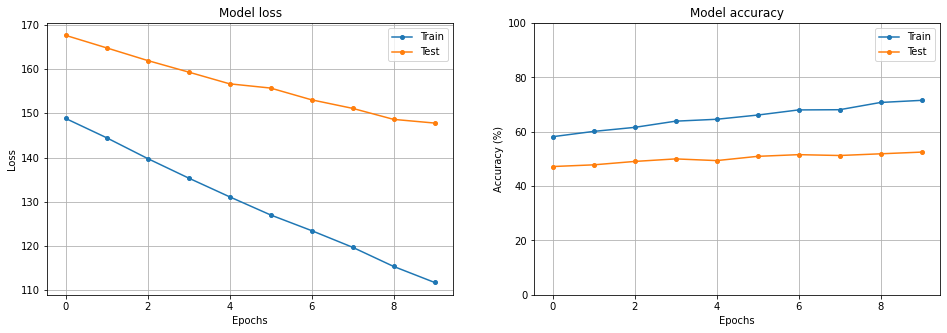

In [25]:
plot_loss_accuracy(loss_rnnbid, acc_rnnbid)

In [26]:
loss_rnnbid, acc_rnnbid = train(model_RNNBid, trn_dl, tst_dl,epochs=10,lr=1e-3,
                        opt='Adam',progress=True)

  0%|          | 0/10 [00:00<?, ?it/s]

E00 loss=[ 95.47,140.66] acc=[ 73.73, 55.62] 
E01 loss=[ 69.69,132.82] acc=[ 83.18, 57.81] 
E02 loss=[ 52.28,129.45] acc=[ 88.57, 60.31] 
E03 loss=[ 39.02,130.85] acc=[ 91.01, 58.44] 
E04 loss=[ 31.67,140.66] acc=[ 92.57, 59.06] 
E05 loss=[ 25.96,137.25] acc=[ 93.66, 60.31] 
E06 loss=[ 23.01,138.87] acc=[ 93.74, 60.00] 
E07 loss=[ 20.43,142.88] acc=[ 94.06, 57.81] 
E08 loss=[ 19.95,140.52] acc=[ 94.06, 59.69] 
E09 loss=[ 18.15,146.36] acc=[ 93.74, 56.56] 


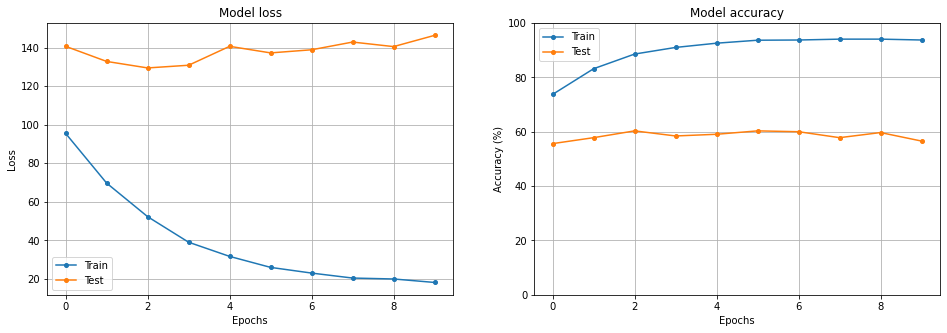

In [27]:
plot_loss_accuracy(loss_rnnbid, acc_rnnbid)

Por el tema del sobreajuste se implementó un ejercicio añadiendo un dropout, los pasos en la pérdida son más pequeños, por lo que también se decidió aumentar el número de épocas. El resultado básicamente es el mismo de los ejercicios anteriores, se sobreajusta muy rápido el modelo.

In [39]:
model_RNNBid_drop = RNN(bidirectional=True, p_drop=0.2)
loss_rnnbid, acc_rnnbid = train(model_RNNBid_drop, trn_dl, tst_dl,epochs=20,lr=1e-3,
                        opt='Adam',progress=True)

  0%|          | 0/20 [00:00<?, ?it/s]

E00 loss=[187.07,191.75] acc=[ 40.90, 38.12] 
E01 loss=[148.74,167.89] acc=[ 54.49, 46.56] 
E02 loss=[120.08,151.22] acc=[ 65.12, 48.75] 
E03 loss=[102.01,143.56] acc=[ 69.36, 50.62] 
E04 loss=[ 83.38,137.89] acc=[ 75.61, 55.62] 
E05 loss=[ 69.59,135.36] acc=[ 81.61, 55.94] 
E06 loss=[ 54.35,128.61] acc=[ 87.02, 60.00] 
E07 loss=[ 44.97,134.20] acc=[ 90.07, 56.88] 
E08 loss=[ 38.19,130.55] acc=[ 90.39, 57.81] 
E09 loss=[ 30.10,128.87] acc=[ 92.10, 59.06] 
E10 loss=[ 26.66,126.55] acc=[ 92.57, 60.62] 
E11 loss=[ 23.32,135.84] acc=[ 93.36, 58.75] 
E12 loss=[ 22.28,135.19] acc=[ 92.57, 57.81] 
E13 loss=[ 20.66,140.29] acc=[ 93.51, 59.69] 
E14 loss=[ 19.28,141.51] acc=[ 94.13, 57.81] 
E15 loss=[ 19.21,150.48] acc=[ 94.21, 58.75] 
E16 loss=[ 17.89,147.59] acc=[ 94.53, 58.75] 
E17 loss=[ 17.10,150.77] acc=[ 94.45, 58.75] 
E18 loss=[ 16.24,147.40] acc=[ 94.69, 60.94] 
E19 loss=[ 16.66,152.65] acc=[ 95.07, 60.00] 


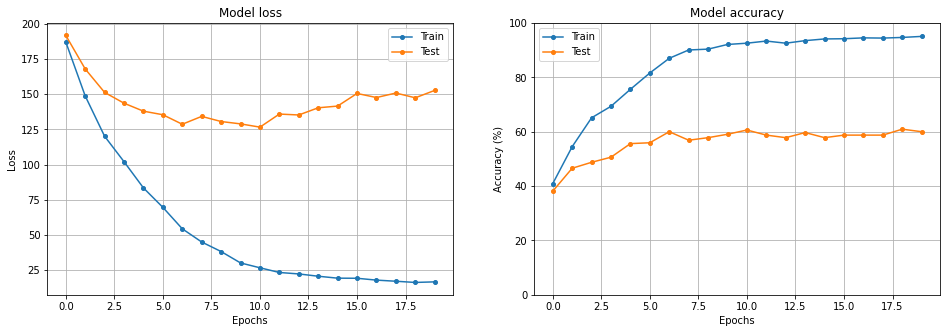

In [40]:
plot_loss_accuracy(loss_rnnbid, acc_rnnbid)

### 4.3 Entrenamiento de la arquitectura CNN

A continuación se realiza el entrenamiento con la arquitectura CNN. Al igual que el ejercicio anterior se experimentó con dos tasas de aprendizaje `lr=1e-3` y `lr=1e-4`.

El número de parámetros es menor que la arquitectura RNN, pero aún así el modelo sigue sobreajustando cerca de los mismos niveles que la arquitectura anterior. Con `lr=1e-4` se observa de mejor manera dicho problema ya que la función de pérdida del conjunto de entrenamiento sigue bajando pero a las pocas épocas la pérdida del conjunto de prueba se comienza a separar, aunque también sigue bajando

In [20]:
loss_cnn, acc_cnn = train(model_CNN, trn_dl, tst_dl,epochs=20,lr=1e-4,
                        opt='Adam',progress=True)

  0%|          | 0/20 [00:00<?, ?it/s]

E00 loss=[225.72,226.92] acc=[ 27.05, 24.06] 
E01 loss=[220.31,221.76] acc=[ 29.32, 25.31] 
E02 loss=[214.65,216.62] acc=[ 29.39, 26.56] 
E03 loss=[209.30,211.93] acc=[ 30.17, 27.50] 
E04 loss=[204.02,207.58] acc=[ 31.50, 29.38] 
E05 loss=[199.25,204.19] acc=[ 32.59, 30.62] 
E06 loss=[195.09,200.70] acc=[ 34.25, 32.50] 
E07 loss=[190.39,197.03] acc=[ 36.82, 35.31] 
E08 loss=[185.73,193.05] acc=[ 39.17, 38.12] 
E09 loss=[181.76,190.55] acc=[ 41.75, 40.00] 
E10 loss=[177.76,187.45] acc=[ 43.08, 40.31] 
E11 loss=[174.43,184.70] acc=[ 44.81, 41.88] 
E12 loss=[170.59,181.95] acc=[ 45.90, 44.38] 
E13 loss=[167.21,179.43] acc=[ 46.90, 44.38] 
E14 loss=[164.02,178.03] acc=[ 47.14, 44.06] 
E15 loss=[160.89,175.34] acc=[ 48.15, 45.31] 
E16 loss=[157.77,173.93] acc=[ 49.50, 45.00] 
E17 loss=[154.78,172.08] acc=[ 50.19, 45.00] 
E18 loss=[151.91,170.79] acc=[ 51.13, 45.62] 
E19 loss=[149.05,168.55] acc=[ 52.31, 45.62] 


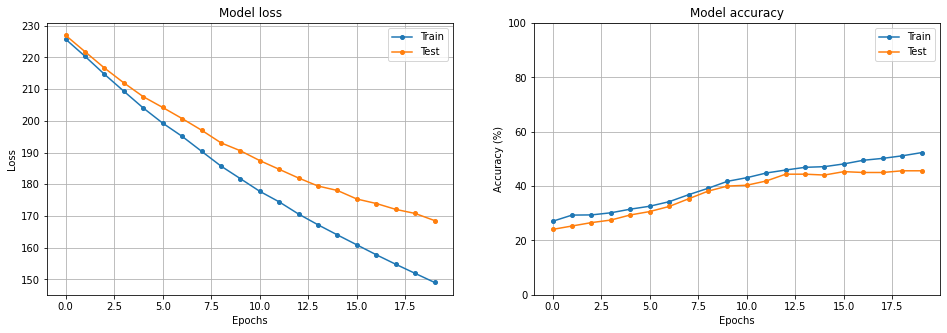

In [21]:
plot_loss_accuracy(loss_cnn, acc_cnn)

In [22]:
loss_cnn, acc_cnn = train(model_CNN, trn_dl, tst_dl,epochs=10,lr=1e-3,
                        opt='Adam',progress=True)

  0%|          | 0/10 [00:00<?, ?it/s]

E00 loss=[136.77,162.02] acc=[ 55.58, 47.50] 
E01 loss=[124.01,160.87] acc=[ 59.42, 46.56] 
E02 loss=[111.90,154.25] acc=[ 64.33, 52.19] 
E03 loss=[102.12,151.40] acc=[ 67.56, 51.25] 
E04 loss=[ 94.28,153.48] acc=[ 70.91, 52.19] 
E05 loss=[ 86.90,149.90] acc=[ 74.11, 56.88] 
E06 loss=[ 88.25,156.20] acc=[ 74.90, 52.50] 
E07 loss=[ 81.98,159.51] acc=[ 76.86, 52.81] 
E08 loss=[ 79.18,162.29] acc=[ 75.38, 54.06] 
E09 loss=[ 69.13,158.09] acc=[ 78.73, 53.44] 


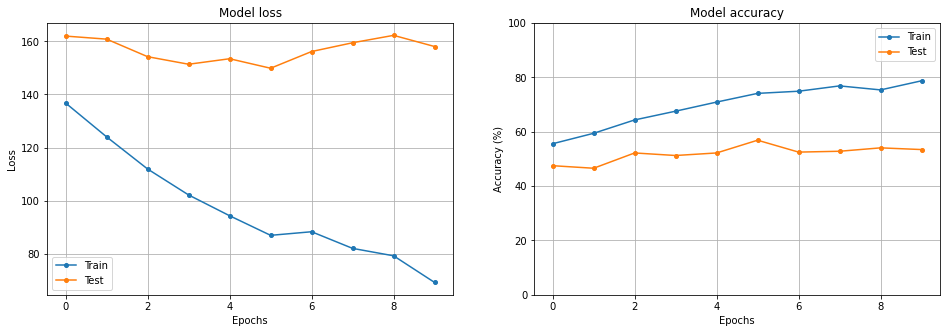

In [23]:
plot_loss_accuracy(loss_cnn, acc_cnn)

### 4.3 Entrenamiento con las arquitecturas modificadas

A continuación se realiza el mismo ejercicio pero ahora con las dos arquitecturas modificadas de tal manera que tengan un número similar de parámetros.

El problema del sobreajuste persiste en ambas arquitecturas modificadas, en el caso de la RNN, como hipótesis, tal vez al disminuir la expresividad en la capa completamente conectada al disminuir las neuronas de entrada, dado que el accuracy aumenta muy poco en función de las épocas.

En el caso de la CNN, sigue un comportamiento similar del ejercicio anterior, las funciones de pérdida van disminuyendo, solo que la pérdida del entrenamiento disminuye a una razón mayor que la pérdidad de la prueba.

#### 4.3.1 Arquitectura RNN modificada

In [26]:
loss_rnnbid_M, acc_rnnbid_M = train(model_RNNBid_M, trn_dl, tst_dl,epochs=20,lr=1e-4,
                        opt='Adam',progress=True)

  0%|          | 0/20 [00:00<?, ?it/s]

E00 loss=[232.85,234.99] acc=[ 17.19, 16.56] 
E01 loss=[232.17,234.33] acc=[ 17.67, 17.19] 
E02 loss=[231.54,233.73] acc=[ 18.13, 17.81] 
E03 loss=[231.11,233.45] acc=[ 17.91, 17.81] 
E04 loss=[230.52,232.83] acc=[ 18.77, 18.44] 
E05 loss=[229.87,232.40] acc=[ 19.15, 18.75] 
E06 loss=[229.30,232.11] acc=[ 19.24, 17.81] 
E07 loss=[228.81,231.81] acc=[ 19.63, 18.44] 
E08 loss=[228.22,231.15] acc=[ 19.31, 18.44] 
E09 loss=[227.73,231.01] acc=[ 20.96, 19.38] 
E10 loss=[227.27,230.63] acc=[ 21.50, 19.69] 
E11 loss=[226.71,230.02] acc=[ 21.03, 19.06] 
E12 loss=[226.29,230.10] acc=[ 21.19, 17.81] 
E13 loss=[225.74,229.36] acc=[ 22.60, 20.31] 
E14 loss=[225.20,229.24] acc=[ 21.66, 18.44] 
E15 loss=[224.67,228.79] acc=[ 22.04, 16.88] 
E16 loss=[224.12,228.41] acc=[ 22.92, 17.50] 
E17 loss=[223.59,228.05] acc=[ 22.99, 18.44] 
E18 loss=[223.09,227.91] acc=[ 23.37, 18.12] 
E19 loss=[222.62,227.40] acc=[ 24.24, 19.38] 


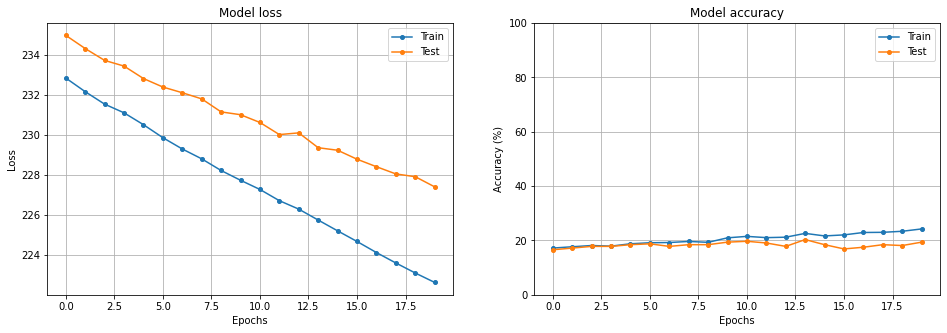

In [27]:
plot_loss_accuracy(loss_rnnbid_M, acc_rnnbid_M)

In [28]:
loss_rnnbid_M, acc_rnnbid_M = train(model_RNNBid_M, trn_dl, tst_dl,epochs=10,lr=1e-3,
                        opt='Adam',progress=True)

  0%|          | 0/10 [00:00<?, ?it/s]

E00 loss=[218.28,224.60] acc=[ 27.44, 20.62] 
E01 loss=[214.04,221.72] acc=[ 29.71, 24.06] 
E02 loss=[209.78,218.87] acc=[ 34.02, 26.88] 
E03 loss=[206.12,216.27] acc=[ 34.55, 27.19] 
E04 loss=[202.64,214.21] acc=[ 35.88, 27.81] 
E05 loss=[199.02,211.87] acc=[ 38.93, 29.06] 
E06 loss=[195.11,209.68] acc=[ 40.58, 29.06] 
E07 loss=[191.59,207.68] acc=[ 42.14, 30.62] 
E08 loss=[187.75,205.30] acc=[ 43.39, 30.31] 
E09 loss=[184.12,203.18] acc=[ 44.33, 31.56] 


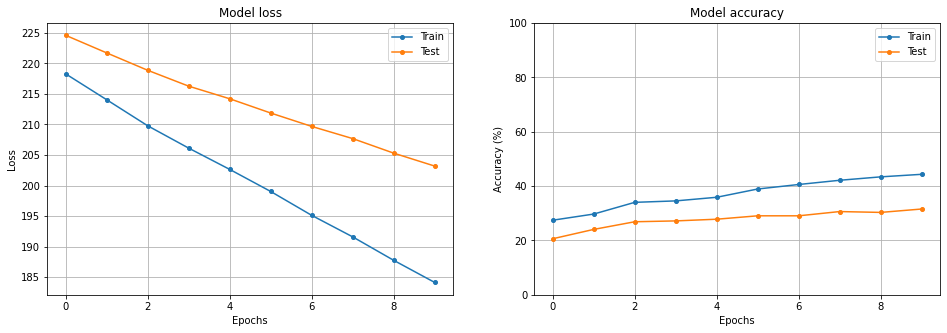

In [29]:
plot_loss_accuracy(loss_rnnbid_M, acc_rnnbid_M)

#### 4.3.2 Arquitectura CNN modificada

In [30]:
loss_cnn_M, acc_cnn_M = train(model_CNN_M, trn_dl, tst_dl,epochs=20,lr=1e-4,
                        opt='Adam',progress=True)

  0%|          | 0/20 [00:00<?, ?it/s]

E00 loss=[239.42,239.50] acc=[ 11.35,  8.12] 
E01 loss=[236.41,236.48] acc=[ 22.67, 17.50] 
E02 loss=[229.40,229.58] acc=[ 25.56, 22.19] 
E03 loss=[222.36,222.84] acc=[ 26.50, 23.44] 
E04 loss=[215.94,216.98] acc=[ 26.66, 24.06] 
E05 loss=[210.17,212.38] acc=[ 29.62, 25.62] 
E06 loss=[205.13,208.20] acc=[ 30.97, 27.50] 
E07 loss=[200.03,204.13] acc=[ 33.22, 29.06] 
E08 loss=[195.09,199.99] acc=[ 34.57, 30.94] 
E09 loss=[190.81,197.07] acc=[ 36.59, 31.88] 
E10 loss=[186.61,193.81] acc=[ 38.71, 34.38] 
E11 loss=[183.11,190.93] acc=[ 40.67, 34.69] 
E12 loss=[179.09,187.89] acc=[ 42.77, 37.19] 
E13 loss=[175.50,184.76] acc=[ 43.77, 40.00] 
E14 loss=[172.08,182.76] acc=[ 45.20, 41.88] 
E15 loss=[168.90,180.34] acc=[ 46.36, 43.12] 
E16 loss=[165.62,178.45] acc=[ 47.15, 42.19] 
E17 loss=[162.62,176.30] acc=[ 48.48, 43.44] 
E18 loss=[159.68,174.93] acc=[ 49.18, 43.12] 
E19 loss=[156.73,172.49] acc=[ 49.73, 43.12] 


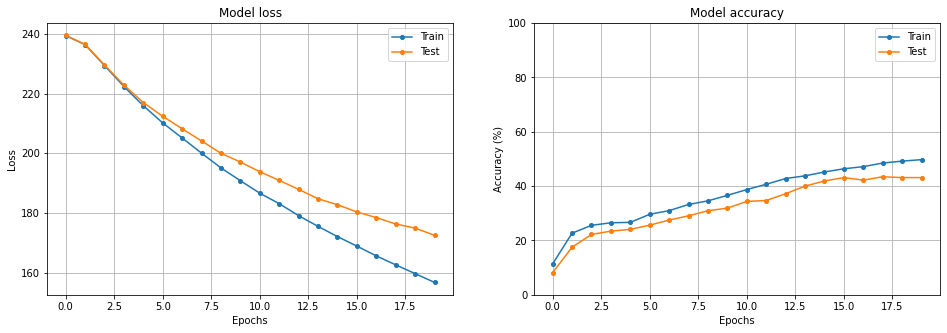

In [31]:
plot_loss_accuracy(loss_cnn_M, acc_cnn_M)

In [32]:
loss_cnn_M, acc_cnn_M = train(model_CNN_M, trn_dl, tst_dl,epochs=10,lr=1e-3,
                        opt='Adam',progress=True)

  0%|          | 0/10 [00:00<?, ?it/s]

E00 loss=[143.85,165.33] acc=[ 53.87, 49.06] 
E01 loss=[130.82,162.28] acc=[ 57.86, 49.06] 
E02 loss=[119.67,155.76] acc=[ 61.68, 50.31] 
E03 loss=[109.57,152.91] acc=[ 64.12, 50.94] 
E04 loss=[103.14,153.24] acc=[ 68.02, 53.12] 
E05 loss=[ 95.95,150.48] acc=[ 68.56, 52.81] 
E06 loss=[ 96.90,154.78] acc=[ 72.87, 54.69] 
E07 loss=[ 92.49,159.30] acc=[ 73.10, 54.38] 
E08 loss=[ 89.93,162.10] acc=[ 72.95, 53.44] 
E09 loss=[ 80.68,160.45] acc=[ 75.77, 53.75] 


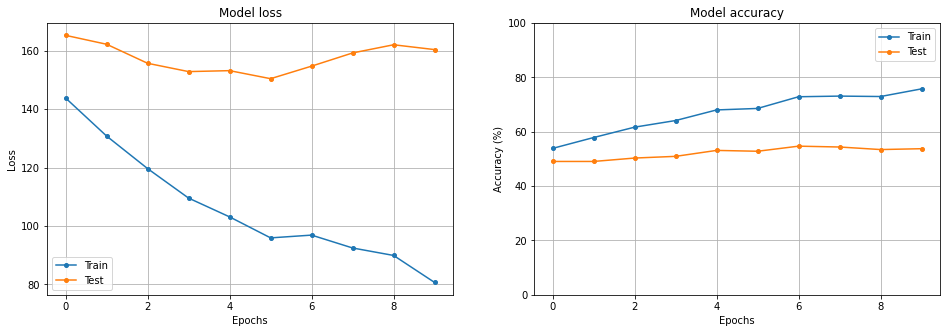

In [33]:
plot_loss_accuracy(loss_cnn_M, acc_cnn_M)